In [2]:
import torch
print(torch.__version__)

1.0.0


# Data import
To handle paths pathlib included in python 3.x comes in handy.
[http://deeplearning.net/data/mnist/] mnist data set from deeplearing, format is a python binary (pkl)

We will use the request library to download zipped binary files and gzip to unzig the file.
The dataset is a serialized numpy array and stored as a binary using pickle. We can use gzip and pickle libries to load the data as a tuple numpy arrays.

In [5]:
from pathlib import Path
import requests
import pickle, gzip

data_dir = Path('data')
mnist_location = data_dir/'mnist'

mnist_location.mkdir(parents=True, exist_ok=True)

url='http://deeplearning.net/data/mnist/'
filename='mnist.pkl.gz'

if not (mnist_location/filename).exists():
    content = requests.get(url+filename).content(mnist_location/filename).open('wb').write(content)
    
with gzip.open(mnist_location/filename) as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

print(x_train.shape)
print(y_train.shape)
print(y_train[49948])


(50000, 784)
(50000,)
3


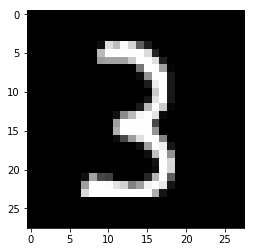

In [110]:
%matplotlib inline

from matplotlib import pyplot
import numpy as np
# each row of x_train conataines a flattend images, we need to reshape it to 28x28 
pyplot.imshow(x_train[49948].reshape((28,28)), cmap="gray")

## Model from scratch
After converting numpy array to a pytorch tensor, we build a neural net from scratch.
The model is built only with tensor operations and the use of gradients.
For the weights, we set requires_grad after the initialization, since we don't want that step included in the gradient. (Note that a trailling _ in PyTorch signifies that the operation is performed in-place.)
Initial weigths with Xavier initialisation by by multiplying with 1/sqrt(n)) 

proceedings.mlr.press/v9/glorot10a/glorot10a.pdf


In [1]:
import torch

x_train,y_train,x_valid,y_valid = map(torch.tensor, (x_train,y_train,x_valid,y_valid))
print(x_train.shape)

NameError: name 'x_train' is not defined

In [112]:
import math
weights = torch.randn(784,10)/math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

Thanks to PyTorch's ability to calculate gradients automatically, we can use any standard Python function (or callable object) as a model! 

So let's just write a plain matrix multiplication and broadcasted addition to create a simple linear model. We also need an activation function, so we'll write `log_softmax` and use it. 

We use the '@' operator for the dot product operation. 

In [113]:
def model(batch):
    return log_softmax(batch @ weights + bias)

def log_softmax(x):
    #unsqueeze x along cols adds extra col x.exp... -> dim(x) X 1, such that result can be broadcasted.
    return x - x.exp().sum(-1).log().unsqueeze(-1)


We will call our function on one batch of data (in this case, 64 images). This is one forward pass. Note that our predictions won't be any better than random at this stage, since we start with random weights.

In [77]:
batch_size = 64
mini_batch = x_train[0:batch_size]
preds = model(mini_batch)
preds[0], preds.shape

(tensor([-2.7073, -2.5841, -2.2565, -2.4422, -2.9635, -1.9985, -1.6499, -2.3197,
         -2.3692, -2.3536], grad_fn=<SelectBackward>), torch.Size([64, 10]))

The preds tensor contains not only the tensor values, but also a gradient function. 

Let's implement negative log-likelihood to use as the loss function (again, we can just use standard Python):

In [114]:
def nll(preds, targets): 
    #pick the prob for correct class from predicted
    probs = preds[range(targets.shape[0]), targets]
    return -probs.mean()
loss_func = nll

In [116]:
target_batch = y_train[0:batch_size]
loss_func(preds, target_batch)

tensor(2.3637, grad_fn=<NegBackward>)

Let's also implement a function to calculate the accuracy of our model. 

For each prediction, if the index with the largest value matches the target value, then the prediction was correct.

In [117]:
def accuracy(probs, targets):
    preds = torch.argmax(probs, dim=1) #argmax along rows
    return (preds==targets).float().mean()

In [118]:
print('accuracy', accuracy(preds, target_batch))

accuracy tensor(0.0312)


We can now run a training loop. For each iteration, we will:

- select a mini-batch of data (of size batch_size)
- use the model to make predictions
- calculate the loss
- `loss.backward()` updates the gradients of the model, in this case, weights and bias.
- We now use these gradients to update the weights and bias. We do this within the torch.no_grad() context manager, because we do not want these actions to be recorded for our next calculation of the gradient. You can read more about how PyTorch's Autograd records operations here.
- We then set the gradients to zero, so that we are ready for the next loop. Otherwise, our gradients would record a running tally of all the operations that had happened (i.e. loss.backward() adds the gradients to whatever is already stored, rather than replacing them).

Handy tip: you can use the standard python debugger to step through PyTorch code, allowing you to check the various variable values at each step. Uncomment set_trace() below to try it out.


In [120]:
from IPython.core.debugger import set_trace

lr = 0.5   # learning rate
epochs = 100 # how many epochs to train for
batch_size = 64
n,c = x_train.shape

for epoch in range(epochs):
    for i in range((n-1)//batch_size + 1):
#         set_trace()
        start_i = i*batch_size
        end_i = start_i+batch_size
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()

In [122]:
loss_func(model(x_train), y_train), accuracy(model(x_train), y_train)

(tensor(0.2444, grad_fn=<NegBackward>), tensor(0.9302))